In [168]:
import pandas as pd
import numpy as np
import sys
import torch.nn as nn
import torch
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader


df = pd.read_csv('data/train.csv')

In [169]:


# # Assuming df is your DataFrame containing the tweets
# # Create the vocabulary

# vocabulary = np.array([])
# for i in range(len(df.index)):
#     words = df['text'].iloc[i].split()  
#     vocabulary = np.append(vocabulary, np.unique(words))  
#     vocabulary = np.unique(vocabulary)

# # Create a dictionary to map each word to an index
# word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

# # Function to one-hot encode a tweet
# def one_hot_encode(tweet, vocab_size):
#     one_hot_vector = np.zeros(vocab_size)
#     for word in tweet.split():
#         if word in word_to_index:
#             index = word_to_index[word]
#             one_hot_vector[index] = 1
#     return one_hot_vector

# # Apply the one-hot encoding to each tweet
# one_hot_encoded_tweets = np.array([one_hot_encode(tweet, len(vocabulary)) for tweet in df['text']])

# # Convert to DataFrame for better readability (optional)
# one_hot_encoded_df = pd.DataFrame(one_hot_encoded_tweets, columns=vocabulary)

# print(one_hot_encoded_df.columns)

In [170]:
one_hot_encoded_df = pd.read_csv("data/one_hot_encoded_df.csv")

In [171]:
one_hot_encoded_df.sum().sum()

671779.0

In [172]:
one_hot_encoded_df = one_hot_encoded_df.loc[:, one_hot_encoded_df.sum() >= 5]

In [173]:
one_hot_encoded_df.sum().sum()

663961.0

In [174]:
one_hot_encoded_df.columns

Index(['Unnamed: 0', '#Beyhive', '#Dance', '#Directioners', '#DnB', '#Dubstep',
       '#EDM', '#Handbag', '#IcesÛ_', '#LGBT',
       ...
       'would', 'year', 'years', 'you', 'you're', 'your', '|', 'Û_', 'ÛÒ',
       'Û÷politics'],
      dtype='object', length=481)

In [175]:
one_hot_encoded_df.sum()

Unnamed: 0       656085.0
#Beyhive              8.0
#Dance                7.0
#Directioners         9.0
#DnB                  7.0
                   ...   
your                 27.0
|                    33.0
Û_                   7.0
ÛÒ                   6.0
Û÷politics           5.0
Length: 481, dtype: float64

In [176]:
# sns.histplot(one_hot_encoded_df.sum(), bins = 40)

In [177]:
all_categories = [1,0]
n_letters = one_hot_encoded_df.shape[1]
n_letters

481

In [178]:
one_hot_encoded_df.columns.to_list()[0]

'Unnamed: 0'

In [179]:
one_hot_encoded_df.columns.get_loc(one_hot_encoded_df.columns.to_list()[0])

0

In [180]:
def letterToIndex(letter):
    return one_hot_encoded_df.columns.get_loc(letter)

def lineToTensor(line):
    line = line.split()
    # We want to have a tensor that, in the first dimension has the sequence index
    # 2nd dimension idk
    # 3d dimension for the one hot element

    # Create empty tensor
    tensor = torch.zeros(len(line), n_letters)

    # Create the sequence tensor
    for li, letter in enumerate(line):
        # print(letterToIndex(letter))
        if letter in one_hot_encoded_df.columns.to_list():
            tensor[li][letterToIndex(letter)] = 1

    return tensor

def lineToTensorEmbedding(line):
    line = line.split()
    # We want to have a tensor that, in the first dimension has the sequence index
    # 2nd dimension idk
    # 3d dimension for the one hot element

    # Create empty tensor
    tensor = torch.zeros(len(line))

    # Create the sequence tensor
    for li, letter in enumerate(line):
        # print(letterToIndex(letter))
        if letter in one_hot_encoded_df.columns.to_list():
            tensor[li] = letterToIndex(letter)+1

    return tensor


def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


In [181]:
# letterToIndex(df.text.iloc[10].split()[0])
# print(df.text.iloc[10].split())
sys.getsizeof(one_hot_encoded_df)

4409952

In [182]:
vocab_list = one_hot_encoded_df.columns.to_list()
vocab_to_index={}

for i, word in enumerate(vocab_list):
    vocab_to_index[word]=i 

In [183]:
def lineToEmbbed(line):
    line = line.split()
    # We want to have a tensor that, in the first dimension has the sequence index
    # 2nd dimension idk
    # 3d dimension for the one hot element

    # Create empty tensor
    tensor = torch.zeros(len(line), n_letters)

    # Create the sequence tensor
    for li, letter in enumerate(line):
        # print(letterToIndex(letter))
        tensor[li][letterToIndex(letter)] = 1

    return tensor

In [184]:
dataset_tensor_list = []
target_list=[]
import random
category = 1

# Convertir cada tensor a 
for i in  df.index:
    # Convert to tensor
    line_tensor = lineToTensorEmbedding(df.text.iloc[i])
    category_tensor = torch.tensor([df.target.iloc[i]], dtype=torch.long)
    # print(category_tensor)
    dataset_tensor_list.append(line_tensor)
    target_list.append(category_tensor)

In [185]:
dataset_tensor_list[0].shape

torch.Size([13])

In [186]:
target = torch.cat(tuple(target_list),dim=0)

In [187]:
padded_dataset = pad_sequence(dataset_tensor_list, batch_first=True)

In [188]:
# for i in range(31):
#     print(padded_dataset[0,i,:].sum())

In [189]:
X_train, X_test, y_train, y_test = train_test_split(padded_dataset.int(),target,test_size=0.3,random_state=42, shuffle=True)

trainTensorDataset= TensorDataset(X_train,y_train)
testTensorDataset = TensorDataset(X_test,y_test)
train_loader = DataLoader(trainTensorDataset, batch_size=100, shuffle=True, drop_last=True)
test_loader = DataLoader(testTensorDataset, batch_size=100, shuffle=True, drop_last=True)

In [190]:
u = next(iter(train_loader))[0]

u.shape

torch.Size([100, 31])

In [191]:
e = nn.Embedding(n_letters+1,40)
e(u).shape

torch.Size([100, 31, 40])

In [192]:
import torch.nn.functional as F
class lstm(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers,embedding_dim):
        super(lstm,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.embedding = nn.Embedding(n_letters+1,embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size,2)

    def forward(self,x):
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers,x.shape[0],self.hidden_size)
        c0 = torch.zeros(self.num_layers,x.shape[0],self.hidden_size)
        out , (hn,cn)= self.lstm(x,(h0,c0))
        out = self.fc1(out[:,-1,:])
        out = F.log_softmax(out)
        return out

In [193]:
input_size = n_letters
hidden_size = 40
num_layers = 2
embedding_dim = 50

In [194]:
from torch import optim
model = lstm(input_size, hidden_size, num_layers,embedding_dim)

In [195]:
# for i in range(31):
#     print(inputs[0,i,:].sum())

In [196]:
from matplotlib import pyplot as plt

def error_plot(train_error_list):
    plt.plot(train_error_list)

In [197]:
vals,indices = torch.max(torch.rand(100,2),dim=1)


torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])


C:\Users\Daniel\AppData\Local\Temp\ipykernel_24568\4252093409.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 31])
to

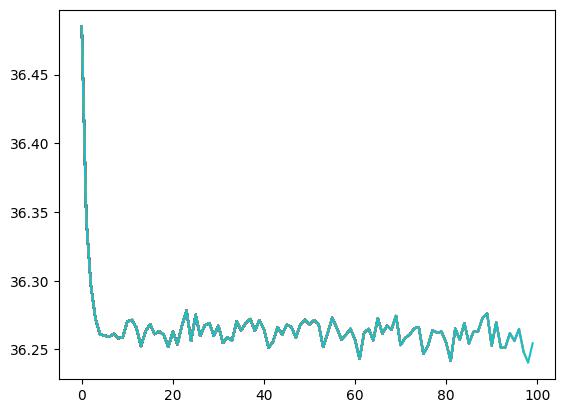

In [198]:
optimizer = optim.SGD(model.parameters(),lr=0.01)
loss_func = nn.NLLLoss()
n_epochs = 100

train_error_list = []
test_error_list = []
for epoch in range(n_epochs):
    epoch_error = 0
    model.train()
    for inputs, targets in train_loader:
        # targets= targets.reshape(-1,1)
        model.zero_grad()
        print(inputs.shape)
        output = model(inputs)
        print(output.shape,targets.shape)
        # print(targets)
        # print(output)
        error = loss_func(output, targets)
        error.backward()
        optimizer.step()
        epoch_error+=error
    train_error_list.append(epoch_error.detach())
    error_plot(train_error_list)
    model.eval()
    for i, (inputs,targets) in enumerate(test_loader):
        outputs = model(inputs)
        vals,indices = torch.max(outputs,dim=1)
        error = (indices == targets).sum().item()
        test_error_list.append(error)

        

    #     outputs = model(inputs)
        

        

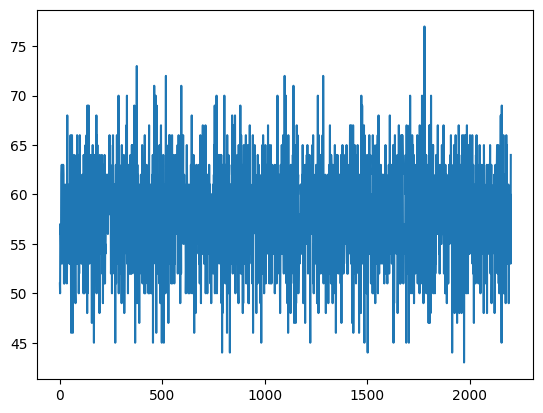

In [199]:
error_plot(test_error_list)

In [200]:
log_softmax = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()
# input to NLLLoss is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target must have 0 <= value < C
target = torch.tensor([1, 0, 4])
print(input)
print(log_softmax(input))
print(target)
loss = loss_fn(log_softmax(input), target)
loss.backward()
# 2D loss example (used, for example, with image inputs)
N, C = 5, 4
loss_fn = nn.NLLLoss()
data = torch.randn(N, 16, 10, 10)
conv = nn.Conv2d(16, C, (3, 3))
log_softmax = nn.LogSoftmax(dim=1)
# output of conv forward is of shape [N, C, 8, 8]
output = log_softmax(conv(data))
# each element in target must have 0 <= value < C
target = torch.empty(N, 8, 8, dtype=torch.long).random_(0, C)
# input to NLLLoss is of size N x C x height (8) x width (8)
loss = loss_fn(output, target)
loss.backward()

tensor([[-2.3525,  0.0203,  0.4898, -0.8390,  0.5840],
        [ 1.5615,  0.7558, -0.4830, -0.2919,  0.1848],
        [-0.4168, -2.1562,  0.7156, -0.9163, -0.3273]], requires_grad=True)
tensor([[-3.9566, -1.5837, -1.1143, -2.4431, -1.0200],
        [-0.6858, -1.4915, -2.7303, -2.5392, -2.0625],
        [-1.7883, -3.5277, -0.6559, -2.2878, -1.6988]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([1, 0, 4])


In [201]:
# sys.getsizeof(padded_dataset1)

In [202]:
# If using in RNN, you need lengths to pack the sequence (if applicable)
sequence_lengths = torch.tensor([tensor.size(0) for tensor in dataset_tensor_list])

# (Optional) Pack the sequence, if used in an RNN
packed_dataset = torch.nn.utils.rnn.pack_padded_sequence(padded_dataset, sequence_lengths, batch_first=True, enforce_sorted=False)


In [203]:
padded_dataset1.shape

NameError: name 'padded_dataset1' is not defined

In [352]:
# sys.getsizeof(padded_dataset.shape)

torch.save(padded_dataset1, 'padded_dataset1.pt')

In [353]:
# import pickle
# with open("padded_dataset1.pkl", "wb") as file:
#     pickle.dump(padded_dataset1, file)

In [354]:
len(dataset_tensor_list)

from torch.utils.data import TensorDataset

TensorDataset(dataset_tensor_list,target_list)

AttributeError: 'list' object has no attribute 'size'